# Nonlinear EnKF

## ----------コードを書く前の下準備----------

### Reference (参考文献)
- 樋口知之編著，上野玄太・中野慎也・中村和幸・吉田亮著，データ同化入門ー次世代のシミュレーション技術ー，朝倉書店，2011．

### Ensemble Kalman Filter (アンサンブルカルマンフィルター)

特徴
- KFでは，平均・共分散行列だけ更新していたが，EnKFでは，アンサンブルメンバー(状態サンプルを幾つも用意しモンテカルロ近似を行う)の更新を考える．
- EnKFでは，非線形・非ガウスにも対応することができる．

対象とする状態空間モデルは，
$$
\begin{align}
x_t=f_t(x_{t-1},v_t),\ v_t\sim q(v_t)\\
y_t=H_tx_t+w_t,\ w_t\sim N(0,R_t)
\end{align}
$$
である．観測モデルに関してはガウス・線形性を仮定するが，非線形の場合でも適切な前処理をすれば適用可能である．

アルゴリズム
1. 初期状態のアンサンブル$\{x_{0|0}^{(i)}\}_{i=1}^N$を生成する．
2. $t=1:T$まで以下を繰り返す．
    1. 一期先予測
        1. システムノイズのアンサンブル$\{v_t^{(i)}\}_{i=1}^N$を$q(v_t)$に従って生成する．
        1. 各アンサンブルメンバーに対して，$x_{t|t-1}^{(i)}=f_t(x_{t-1|t-1}^{(i)},v_t)$を計算する．
    1. フィルタ
        1. 観測ノイズのアンサンブル$\{w_t^{(i)}\}_{i=1}^N$を$N(0,R_t)$に従って生成する．
        1. 共分散行列$\hat V_{t|t-1}$，カルマンゲイン$\hat K_t$を後述する式で計算する．
        1. 各アンサンブルメンバーに対して，$x_{t|t}^{(i)}=x_{t|t-1}^{(i)}+\hat K_t(y_t+\breve w_t^{(i)}-H_tx_{t|t-1}^{(i)})$を計算し，フィルタアンサンブル$\{x_{t|t}^{(i)}\}_{i=1}^N$を得る．

フィルタB.bの計算式は以下の通りである．
$$
\begin{align}
\breve x_{t|t-1}^{(i)}=x_{t|t-1}^{(i)}-\frac{1}{N}\sum_{j=1}^Nx_{t|t-1}^{(j)}\\
\hat V_{t|t-1}=\frac{1}{N-1}\sum_{j=1}^N\breve x_{t|t-1}^{(j)}\breve x_{t|t-1}^{(j)}{}^T\\
\breve w_t^{(i)}=w_t^{(i)}-\frac{1}{N}\sum_{j=1}^Nw_t^{(i)}\\
\hat R_t=\frac{1}{N-1}\sum_{j=1}^N\breve w_t^{(j)}\breve w_t^{(j)}{}^T
\end{align}
$$

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > phase2 > Python_source : saving place for source
- DataAssimilation > phase2 > plot : saving place for plot result

バージョンについて
- Mac OS 10.13
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1

In [1]:
# install packages
from IPython.core.display import display
import time
import math

import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE

import sys
sys.path.append("../")
from pyassim import *

## Lorenz63 で試してみた

In [2]:
# update
def Lorenz_update(state, param, dt) :
    u = state[0]
    v = state[1]
    w = state[2]
    p = param[0]
    r = param[1]
    b = param[2]
    new_state = np.zeros_like(state)
    new_state[0] = u + dt * p * (- u + v)
    new_state[1] = v + dt * (- u*w + r*u - v)
    new_state[2] = w + dt * (u*v - b*w)
    return new_state

# perfect simulation function
def Lorenz_perfect(initial, param, time, dt) :
    t = 0
    state = initial
    l = math.ceil(time / dt) + 1
    u = np.zeros(l + 1)
    v = np.zeros(l + 1)
    w = np.zeros(l + 1)
    u[0] = initial[0]
    v[0] = initial[1]
    w[0] = initial[2]
    for i in range(l) :
        state = Lorenz_update(state, param, dt)
        u[i + 1] = state[0]
        v[i + 1] = state[1]
        w[i + 1] = state[2]
    return u, v, w

def Lorenz_perfect_noise(initial, param, time, dt, sigma) :
    t = 0
    state = initial
    l = math.ceil(time / dt) + 1
    u = np.zeros(l + 1)
    v = np.zeros(l + 1)
    w = np.zeros(l + 1)
    u[0] = initial[0]
    v[0] = initial[1]
    w[0] = initial[2]
    for i in range(l) :
        noise = rd.normal(0, sigma, size = 3)
        state = Lorenz_update(state, param, dt) + noise
        u[i + 1] = state[0]
        v[i + 1] = state[1]
        w[i + 1] = state[2]
    return u, v, w

# initial particle
def Initial_particle(mu_0, initial_sd, n_particle) :
    return rd.normal(mu_0, initial_sd, size = n_particle)

In [3]:
# parameter
#a = -2
#b = -1
n_dim = 3
n_particle = 10**2
# sys_sigma, obs_sigma are variance
sys_sigma = 3
obs_sigma = 2.615
# make sigma is standard deviation
make_sigma = 0.1
initial = np.array([5.0, 5.0, 5.0])
mu_0 = np.array([4.5, 5.5, 5.5])
initial_sd = 0.01
param = np.array([10, 28, 8 / 3])
dt = 0.01
end_time = 15.0

In [4]:
# perfect simulation
perf_u, perf_v, perf_w = Lorenz_perfect(initial, param, end_time, dt)
# perfect simulation + noise
perf_u_noise, perf_v_noise, perf_w_noise = Lorenz_perfect_noise(initial,
                                                                param, end_time, dt, make_sigma)

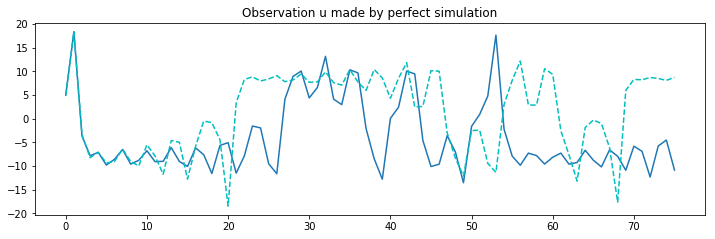

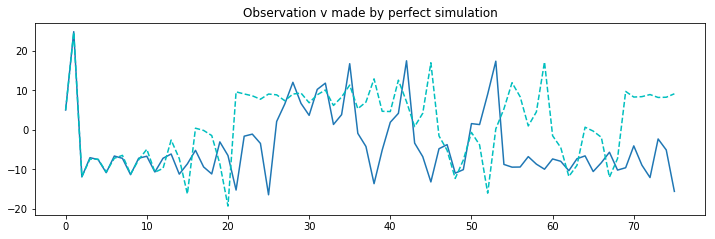

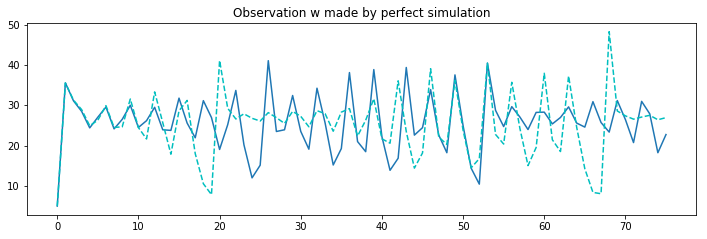

In [5]:
# plot observation from perfect simulation data
time_interval = 20
time_step = math.ceil(end_time / dt) + 1
time_data = np.linspace(0, end_time, time_step)
obs_u = np.zeros(time_step)
obs_v = np.zeros(time_step)
obs_w = np.zeros(time_step)
obs_u[:] = np.nan
obs_v[:] = np.nan
obs_w[:] = np.nan
obs_u[::time_interval] = perf_u_noise[::time_interval]
obs_v[::time_interval] = perf_v_noise[::time_interval]
obs_w[::time_interval] = perf_w_noise[::time_interval]

plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 1)
plt.plot(obs_u[::time_interval], label = 'obs_u')
plt.plot(perf_u[::time_interval], linestyle = '--', color = 'c', label = 'perf_u')
plt.title("Observation u made by perfect simulation")

plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 2)
plt.plot(obs_v[::time_interval], label = 'obs_v')
plt.plot(perf_v[::time_interval], linestyle = '--', color = 'c', label = 'perf_v')
plt.title("Observation v made by perfect simulation")

plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 3)
plt.plot(obs_w[::time_interval], label = 'obs_w')
plt.plot(perf_w[::time_interval], linestyle = '--', color = 'c', label = 'perf_w')
plt.title("Observation w made by perfect simulation")

plt.show()

In [6]:
print(obs_u)

[  5.                  nan          nan ...          nan          nan
 -10.86002691]


In [7]:
y = np.c_[obs_u, obs_v, obs_w]
y.shape

(1501, 3)

In [8]:
y[:5]

array([[ 5.,  5.,  5.],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [9]:
def transition_function(state, noise):
    param = np.array([10, 28, 8 / 3])
    dt = 0.01
    
    u = state[0]
    v = state[1]
    w = state[2]
    p = param[0]
    r = param[1]
    b = param[2]
    new_state = np.zeros_like(state)
    new_state[0] = u + dt * p * (- u + v)
    new_state[1] = v + dt * (- u*w + r*u - v)
    new_state[2] = w + dt * (u*v - b*w)
    return new_state + noise

In [10]:
def observation_function(state):
    return state

In [11]:
a=np.arange(6).reshape(2,3)
np.vstack([a,a]).shape

(4, 3)

In [14]:
st = time.time()
nenkf = NonlinearEnsembleKalmanFilter(y, transition_functions = [transition_function],  
                            observation_functions = [observation_function],
                            initial_mean = initial , 
                             n_dim_sys = 3, n_dim_obs = 3, n_particle = 50,
                             transition_noise = (rd.multivariate_normal, [np.zeros(3), sys_sigma**2 * np.eye(3)]),
                            observation_covariance = obs_sigma * np.eye(3), dtype = np.float16)
nenkf.forward()
nenkf.smooth(lag = 100)
print(time.time() - st)

 filter calculating... t=246/1501

 smooth calculating... t=1502/150123.96873688697815


In [13]:
st = time.time()
enkf = EnsembleKalmanFilter(y, transition_functions = [transition_function],  initial_mean = initial , 
                             n_dim_sys = 3, n_dim_obs = 3, n_particle = 50,
                             transition_noise = (rd.multivariate_normal, [np.zeros(3), sys_sigma**2 * np.eye(3)]),
                            observation_covariance = obs_sigma * np.eye(3), dtype = np.float16)
enkf.forward()
enkf.smooth(lag = 100)
print(time.time() - st)

 filter calculating... t=276/1501

 filter calculating... t=556/1501

 filter calculating... t=836/1501

 filter calculating... t=1101/1501

 filter calculating... t=1380/1501

 smooth calculating... t=1502/150113.525727033615112


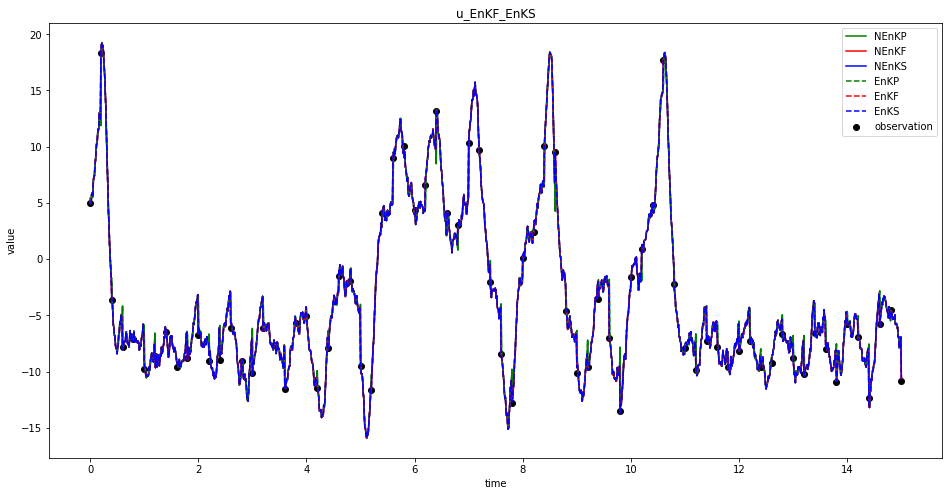

In [15]:
T = len(obs_u)
        
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], color = "k",
            marker = 'o', label = "observation")

plt.plot(time_data, nenkf.get_predicted_value(0), color = "g", label = "NEnKP")
plt.plot(time_data, nenkf.get_filtered_value(0), color = "r", label = "NEnKF")
plt.plot(time_data, nenkf.get_smoothed_value(0), color = "b", label = "NEnKS")

plt.plot(time_data, enkf.get_predicted_value(0), linestyle="--", color = "g", label = "EnKP")
plt.plot(time_data, enkf.get_filtered_value(0), linestyle="--", color = "r", label = "EnKF")
plt.plot(time_data, enkf.get_smoothed_value(0), linestyle="--", color = "b", label = "EnKS")
        
#for t in range(T):
#    plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2, alpha = 0.1)
        
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_EnKF_EnKS")
plt.show()

- lag 500 取ったが，あまり平滑化されている気配は感じられない
    - 粒子数が足りないせいか，コーディングミスか，固定ラグ平滑化のせいか
- smoothing されていないのは，各時刻に観測があることを前提とした smoothing の式であるからかもしれない

## 通常の時系列で試してみた

In [13]:
df = pd.read_csv('../../data/rhine-river-near-basle-switzerla.csv')

In [14]:
df.head()

,Year,Data
0,1807,864.884
1,1808,1033.141
2,1809,826.923
3,1810,1018.777
4,1811,1118.296


In [15]:
y = np.array(df['Data'])

In [16]:
y /= 1000

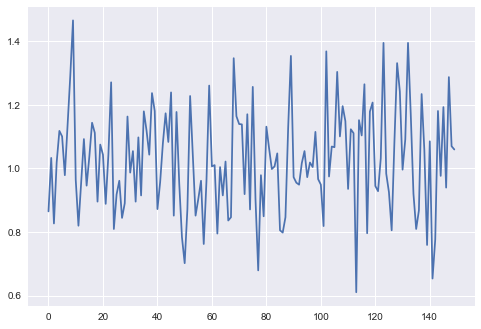

In [17]:
plt.plot(y)

In [18]:
len(y)

150

In [19]:
ekf = Ensemble_Kalman_Filter(y, initial_mean = [0.8] , n_dim_sys = 1, n_dim_obs = 1)
ekf.smooth(lag = 80)

 smooth calculating... t=150/150

In [19]:
#ekf2 = Ensemble_Kalman_Filter(y, transition_functions = [lambda x,v : 0.9*x+v],  initial_mean = [0.8] , n_dim_sys = 1, n_dim_obs = 1)
#ekf2.filter()

 filter calculating... t=149/150

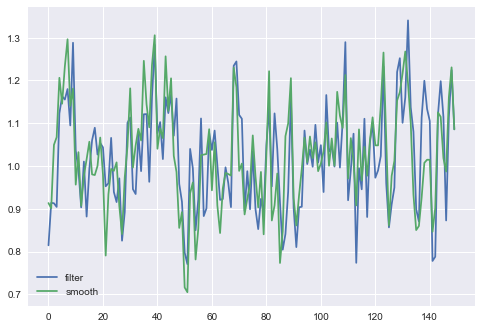

In [20]:
#plt.plot(ekf.get_predicted_value(), label = 'predict')
plt.plot(ekf.get_filtered_value(), label = 'filter')
plt.plot(ekf.get_smoothed_value(), label = 'smooth')
#plt.plot(ekf2.get_filtered_value(), label = 'AR')
#plt.plot(y, label = 'obs')
plt.legend(loc = 'best')

- 状態遷移関数 x+v というランダムウォークな適当な設定なのでまあこんなもん笑
- smooth 感がほんとに感じられない〜

In [11]:
len(np.asarray(ekf.f).shape)

0

色々と改善方針

- カルマンゲイン計算しているのをやめて，Zを計算するように変更？

なんか計算

In [23]:
a = np.arange(4).reshape(2,2)+1
b = np.arange(2).reshape(2, 1) + 1
a/b

array([[1. , 2. ],
       [1.5, 2. ]])

In [2]:
from scipy import linalg, sparse

In [18]:
def GramSchmidt(matrix, eps = 1e-4):
    mat = matrix.astype(np.float64)
    for i in range(mat.shape[1]):
        for j in range(i):
            r = np.dot(mat[:,i], mat[:,j]);
            mat[:,i] -= r * mat[:,j];
        norm = linalg.norm(mat[:,i])
        if norm < eps:
            for k in range(i, mat.shape[1]):
                mat[:,k] = 0.0
        mat[:,i] *= 1.0 / norm
    return mat.astype(matrix.dtype)

In [22]:
a

array([[0., 1.],
       [2., 3.]], dtype=float32)

In [24]:
a = np.arange(4).reshape(2,2).astype(np.float32)
GramSchmidt(a)

array([[0., 1.],
       [1., 0.]], dtype=float32)